In [1]:
# Import all the libraries we need
import os

import parsl
from parsl import python_app
from parsl.config import Config
from parsl.channels import LocalChannel
from parsl.executors import HighThroughputExecutor
from parsl.providers import LocalProvider

# Helper functions
from grouputils import initialize_stager
from grouputils import plot_tiles

## Background

The first step in our workflow is to "stage" our data. Staging the data encompasses the following pre-processing tasks:

- simplify the polygons 
- set an input CRS if one is missing
- reproject the data when required
- add additional properties to each polygon, including:
  - the centroid x and y coordinates
  - area
  - a unique ID
  - name of the file that the
  polygon originated from
- break each input file into [standardized tiles](https://docs.opengeospatial.org/is/17-083r2/17-083r2.html)
- identify duplicate polygons (those that occur in two staged tiles)
- save them to disk, following a file hierarchy and naming format for x, y, and z coordinates of the tiles

Here is a diagram showing what the most important step, the last one, looks like.

![](https://raw.githubusercontent.com/PermafrostDiscoveryGateway/viz-staging/develop/docs/images/staging_tldr.png)

We will use some methods from the `pdgstaging` library to stage our tiles. The first step, is to initalize the `TileStager`. The `TileStager` is a class with a method `stage`, which works on a single vector file.

### Initalize the stager

Fist we need to use the `initialize_stager` function to instantiate the `TileStager` object. The only argument to this function is `dir_input`, the directory of input data.

Input vector files are located **in `/home/shares/example-pdg-data/SCC-2023`**

In [2]:
# Execute the initialize_stager function with the filepath for the input data
# Save the result to a variable called iwp_stager
iwp_stager = initialize_stager('/home/shares/example-pdg-data/SCC-2023')

The `iwp_stager` object works as a tool that communicates the configuration settings to the staging function. The stager tells the staging function:
- where to pull the input files from
- where to write the staged tiles
- the coordinate reference system to use, by passing the TileMatrixSet
- whether the input data should be deduplicated, etc.

Next let's use it to get a list of files to stage.

In [3]:
files_to_stage = iwp_stager.tiles.get_filenames_from_dir('input')

In [4]:
files_to_stage

['/home/shares/example-pdg-data/SCC-2023/GE01_20180907225323_1050010012146100_18SEP07225323-M1BS-502583898040_01_P003_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/QB02_20060817224711_101001000525AC00_06AUG17224711-M1BS-052220659010_01_P001_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/QB02_20090828220948_101001000A2D0F00_09AUG28220948-M1BS-052802016020_01_P003_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/QB02_20090828220951_101001000A2D0F00_09AUG28220951-M1BS-052802016020_01_P004_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/QB02_20090828220955_101001000A2D0F00_09AUG28220955-M1BS-052802016020_01_P005_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/QB02_20110722215239_101001000DD28400_11JUL22215239-M1BS-052802088070_01_P001_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/WV02_20130820230329_1030010025318400_13AUG20230329-M1BS-500124702020_01_P003_u16rf3413_pansh.gpkg',
 '/home/share

## Stage one file

Here is an example of how to run the stager on one file. We use the `stage` method on the `iwp_stager` object, with a path to a file as the argument to the method.

In [ ]:
example_file = files_to_stage[1]
iwp_stager.stage(example_file)

Check out your driectory `scalable-computing-course/group-project` - you'll see that a subdirectory called `staged` has been created. This directory contains the `.gpkg` files output. To check how many staged files were created, you can run the command: `find group-project/staged -type f | wc -l`

### Estimating total computation time

Based on how long staging one file took, estimate how long that would take to stage all 11 input files, serially.

In [ ]:
# Estimate computation time for 11 files


Due to the different sizes of each input file, it can be difficult to predict how long it will actually take. All the files that make up this small data sample are very small relative to other files in the compelete dataset, so our calculation results in an underestimate when we scale up the workflow. The largest file in this dataset sample is 88.2 MB, and an average ice wedge polygon file is around 400 MB, resulting in a processing time of many minutes.

Additionally, a computer's resources are limited by the amount of people concurrently processing files and writing them (I/0 wait). When a machine is writing a file, it is not "working", it's waiting for the file to be written. When many users are writing files, a queue builds up.

### Scaling up the workflow

Computation time also depends on the machine you're working on. With more input GeoPackages from this dataset, it is common to run into an "out of memory" error that cancels the entire process when run serially. Tools such as `htop` and `glances` help with monitorting memory, CPU usage, and which accounts are runnning each process on a server. If a process is running slower than you would expect, you can check these dashboards to diagnose the problem. If your dashbord shows your memory is steadily increasing and reaches >90%, that's a sign your process will crash! When doing test runs with your data, it is important to monitor your memory to determine how the usage will increase in addition to the number of output files. 

The complete ice wedge polygon dataset contains **26,530** GeoPackages. How long would it take to process all of them serially, assuming they all took the same amount of time as our example file? Recall this your answer will be an underestimate!

In [ ]:
# Estimate computation time for all 26,530 files


### Visualizing staged tiles

As the number of files gets bigger, things get out of hand quickly. Luckily for us, this problem is pleasingly parallel. The staging of each file is completely independent of the others. So, let's set this up as a `parsl` workflow using the skills we learned in Section 4: Pleasingly Parallel Programming.

Just to get a sense of what happened, let's plot the result of our test staging effort using a `plot_tiles` helper function we wrote for this activity.

In [ ]:
plot_tiles(iwp_stager)

Finally, let's remove the files we just created (including the staging summary csv file that's generated with the staged files) to prepare to run this over all of the files. If we don't do this, polygons will get appended to the staged files which will result in duplication.

We also need to refresh the stager to its original state for a new staging instance.

In [12]:
# Remove files and staged directory
#os.system(f'rm -rf {iwp_stager.config.get("dir_staged")}')
#os.system(f'rm {iwp_stager.config.get("filename_staging_summary")}')

# Refresh the stager
iwp_stager = initialize_stager("/home/shares/example-pdg-data/SCC-2023")

## Staging in parallel

#### Which exector should we use?

First set up the configuration for `parsl` using `config`, and a `HighThroughputExecutor` (`parsl` has many executor options). We are working on a single node with 88 cores, so we have the choice between `HighThroughputExecutor` or `ThreadPoolExecutor`. We chose to use `HighThroughputExecutor` because it avoids long job scheduler queue delays by acquiring a set of resources initially, allowing it to schedule _multiple tasks_ on a single node! 

Using the other exector actually makes our execution time longer. With this set of input data and imported libraries, achieveing parallelization with the `ThreadPoolExecutor` is largely limited by python's "global interpreter lock". This is a lock that allows only 1 thread to hold control of the python interpreter. One way to avoid the global interpreter lock is to use multi-processing approach, rather than a multi-threaded approach. This works because each python process gets its own interpreter and memory space. This is exactly what we are doing with the `HighThroughputExecutor`! This executor coordinates tasks over several cores in a node.

#### Configuration

For the executor, set the `max_workers` to 11, and set the `max_blocks` to 1. This will spread our work over 11 processes on the server.

A "block" is the most basic unit of resources to be aquired from a provider. A block has a different definition depending on the kind of server you're working on (whether you have been allocated multiple nodes, or do work on _one node_ that has multiple _cores_). We are working on a multi-core node, we wouldn't want to set our blocks to be higher than 1, because a block _at minimum_ is 1 node.

There are plenty of `parsl` configuration options out there, but many are not relevant for our server and do not speed up the process. 

Make sure you pass the bash command you use to invoke your virtual environment to the `worker_init` argument as a string.

In [8]:
# TEMPLATE FOR PARSL CONFIG:

# activate_env = 'workon scomp'
# htex_config = Config(
#   executors=[
#       HighThroughputExecutor(
#           ..., 
#           provider = LocalProvider(
#             worker_init = activate_env,
#             ...
#           )
#       )
#   ]
# )

activate_env = 'workon scomp'
htex_local = Config(
    executors = [
        HighThroughputExecutor(
            max_workers = 11, # Caps the number of workers launched per node
            provider = LocalProvider(
                worker_init = activate_env,
                max_blocks = 1
            )
        )
    ],
)
parsl.clear()
parsl.load(htex_local)

Next, set up your Parsl app to run the `stage` method in parallel. You'll need to pass 2 arguments to the app function:
1. The path to the input file.
2. The `TileStager` instance we created earlier.

Note how the function returns the input path. This will give us something to interate over, since the `stage` method returns `None` (and writes files!)

In [13]:
# Make a Parsl app that uses the stage method
# Function arguments: path, stager
#files_to_stage



@python_app
def stager_danger(stager, file):
    stager.stage(file)
    return file

result = []
def iter_irate(files_to_stage):
    for file in files_to_stage:
        out = stager_danger(iwp_stager, file)
        result.append(out)
        return result
    
    
def hope_for_futures(files_to_stage):
    results = iter_irate(files_to_stage)
    done = [app_future.result() for app_future in results]
    print(done)

#stager_danger(iwp_stager, files_to_stage[1])
hope_for_futures(files_to_stage = files_to_stage)

['/home/shares/example-pdg-data/SCC-2023/GE01_20180907225323_1050010012146100_18SEP07225323-M1BS-502583898040_01_P003_u16rf3413_pansh.gpkg']


In [9]:
files_to_stage[1]

'/home/shares/example-pdg-data/SCC-2023/QB02_20060817224711_101001000525AC00_06AUG17224711-M1BS-052220659010_01_P001_u16rf3413_pansh.gpkg'

Now, execute the app in parallel over all of the `files_to_stage`. In this solution, we use a simple loop to run our `parsl` app, and then list comprehension to retrieve the result from our futures.

In [ ]:
# Execute the app using app.futures






Don't forget to shutdown your executor and clear `parsl`.

In [14]:
# Shutdown and clear the parsl executor
htex_local.executors[0].shutdown()
parsl.clear()

Now we can check out the `plot_tiles` result again (which will only plot the first 45 of our tiled files)

451 are present.             Only plotting the first 45 files.


DriverError: database is locked

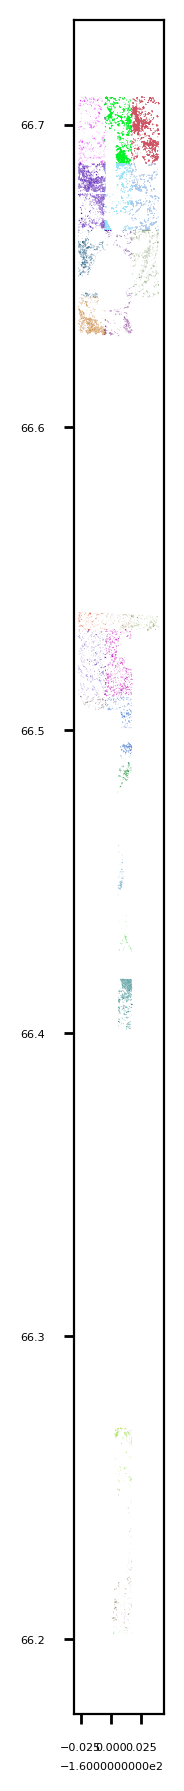

In [16]:
plot_tiles(iwp_stager)

## Bonus Questions

This process took the original 11 files, ranging in size from 6 MB to 88 MB (all files = about 0.5 GB), and tiled them into 454 geopackage files. 

Discuss in your groups whether you suspect this process is CPU bound, I/O bound, memory bound, or network bound. 

How would you figure it out for sure?

Why would you want to know?



## Bonus Exercise: Count the number of polygons

Once you have established your workflow in using a notebook, executing your code in a `.py` script will save you time in the future, especially if you intend to run your workflow again and again on new input data, which is the case for the ice wedge polygon dataset! Additionally, scripts are a more common way to share code with collaborators since they have simple formatting on the backend, and are easier to handle with GitHub. 

Instead of executing the same code we just ran in this notebook, let's use a script to explore the data we just produced. Using the command we learned earlier (`find group-project/staged -type f | wc -l`) we can check the number of output files. There should be 454. Each of those is a GeoPackage that contains many polygons and their attributes. 1 polygon = 1 row. 

1. Create a blank script in your `scalable-computing-course` with the `touch` command: `touch count_polygons.py`
2. At the top of the script, import the packages you'll need:
```python
import geopandas as gpd
from grouputils import initialize_stager
```
3. Create a loop that counts the total number of polygons in the staged files. Add in any other code you like to explore the polygon attributes.
4. Run your script with the command `python count_polygons.py`. Make sure your environment is activated in the terminal first.

A great command line tool for running long scripts on servers is `tmux`, which will continue running the script even if your connection to the server is disconnected! It also frees you up to do other work on the server while that chugs away in the background.